# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107015b80>>
Traceback (most recent call last):
  File "/Users/nicost/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# SETUP

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [ ]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-besra'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [ ]:
train_data = pd.read_csv('/kaggle/input/casa-dataset-2/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset-2/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset-2/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [ ]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [ ]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts

In [ ]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    # if len(train_data) > 0:
    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

    # return None, None, None, None

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, model_num):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Setup Aspect Model
    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    ) 
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue
    
    # Setup Sentiment Model
    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)
    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare models
    aspect_model, aspect_optimizer = accelerator.prepare(aspect_model, aspect_optimizer)
    sentiment_model, sentiment_optimizer = accelerator.prepare(sentiment_model, sentiment_optimizer)

    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare train loaders
    aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    accelerator.wait_for_everyone()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{model_num+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nModel {model_num+1} of aspect detection, Accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{model_num+1}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{model_num+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nModel {model_num+1} of sentiment analysis, accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{model_num+1}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Model {model_num+1} - Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(result['accuracy'])
        metrics[1].append(result['f1_micro'])
        metrics[2].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

In [21]:
def besra_sampling(aspect_models, sentiment_models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    for aspect_model in aspect_models:
        aspect_model.to(device)
        aspect_model.eval()

    for sentiment_model in sentiment_models:
        sentiment_model.to(device)
        sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_aspect_dataset = AspectDetectionDataset(current_X_train, current_y_train, label_mapping, tokenizer, max_length=sequence_length)
    label_aspect_probs = labeled_aspect_dataset.get_global_probs()
    class_aspect_probs = labeled_aspect_dataset.get_per_class_probs()

    _, _, labeled_sentiment_dataset, _ = build_sentiment_dataset(
        aspect_models[0].device, labeled_aspect_dataset, labeled_aspect_dataset, aspect_models[0], tokenizer, max_length=sequence_length
    )
    label_sentiment_probs = labeled_sentiment_dataset.get_global_probs()
    class_sentiment_probs = labeled_sentiment_dataset.get_per_class_probs()
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()
    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        model_probs = []
        score_changes = []
        
        for model in aspect_models:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging

        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        mean_probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(mean_probs)):
            score_diff = []
            for class_idx in range(mean_probs.shape[1]):
                predicted_prob = mean_probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_aspect_probs, label_aspect_probs, class_idx))

                if int(mean_probs[i][class_idx].round()) != 1:
                        aspects.append(aspect_list[class_idx])
                        data.append(batch['ori_text'][i])
                        labels.append(batch['ori_label'][i][class_idx])
                        indices.append(batch['ori_indices'][i])

            aspect_outputs[batch['ori_indices'][i].item()] = np.mean(score_diff)
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for sentiment_model in sentiment_models:
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    accelerator.wait_for_everyone()
    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        mean_probs = np.mean(sentiment_outputs[indices], axis=1)

        score_changes = []
        for prob in mean_probs:
            score_diff = []
            for class_idx in range(len(prob)):
                predicted_prob = prob[class_idx]
                score_diff.append(compute_expected_score_change(predicted_prob, class_sentiment_probs, label_sentiment_probs, class_idx))

            score_changes.append(np.mean(score_diff))
        sentiment_outputs[indices] = np.mean(score_changes)

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = (val + aspect_outputs[key]) / 2

        score_changes = np.array(list(aspect_outputs.values())).reshape(-1, 1)

        collected_indices = set()
        thresholds = []

        target_samples = math.ceil(0.1 * len(X_pool))

        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its score changes
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 10)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances <= local_threshold]
                collected_indices.update(below_threshold_indices)

            # Handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_aspect_accuracies = manager.list()
        model_aspect_f1_micros = manager.list()
        model_aspect_f1_macros = manager.list()
        model_sentiment_accuracies = manager.list()
        model_sentiment_f1_micros = manager.list()
        model_sentiment_f1_macros = manager.list()
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()

        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (
                current_train_size, 
                train_indices, 
                (model_aspect_accuracies, model_aspect_f1_micros, model_aspect_f1_macros), 
                (model_sentiment_accuracies, model_sentiment_f1_micros, model_sentiment_f1_macros),
                (model_accuracies, model_f1_micros, model_f1_macros), 
                i,
                j
            )
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        aspect_accuracies.append(np.mean(model_aspect_accuracies))
        aspect_f1_micros.append(np.mean(model_aspect_f1_micros))
        aspect_f1_macros.append(np.mean(model_aspect_f1_macros))
        sentiment_accuracies.append(np.mean(model_sentiment_accuracies))
        sentiment_f1_micros.append(np.mean(model_sentiment_f1_micros))
        sentiment_f1_macros.append(np.mean(model_sentiment_f1_macros))
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        aspect_models = []
        sentiment_models = []
        for j in range(3):
            aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{j+1}')
            sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{j+1}')
            
            aspect_models.append(aspect_model)
            sentiment_models.append(sentiment_model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_models, 
            sentiment_models, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            tokenizer,
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    for j in range(3):
        set_seed(seed[j])
        args = (
            current_train_size, 
            train_indices, 
            (model_aspect_accuracies, model_aspect_f1_micros, model_aspect_f1_macros), 
            (model_sentiment_accuracies, model_sentiment_f1_micros, model_sentiment_f1_macros),
            (model_accuracies, model_f1_micros, model_f1_macros), 
            i,
            j
        )
        notebook_launcher(train_model, args, num_processes=2)

    data_used.append(current_train_size)
    aspect_accuracies.append(np.mean(model_aspect_accuracies))
    aspect_f1_micros.append(np.mean(model_aspect_f1_micros))
    aspect_f1_macros.append(np.mean(model_aspect_f1_macros))
    sentiment_accuracies.append(np.mean(model_sentiment_accuracies))
    sentiment_f1_micros.append(np.mean(model_sentiment_f1_micros))
    sentiment_f1_macros.append(np.mean(model_sentiment_f1_macros))
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [ ]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7701, F1 Micro: 0.8685, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5949, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5663, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5413, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.485, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Epoch 6/10, Train Loss: 0.4934, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.4861, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4478, Accuracy: 0.7924, F1 Micro: 0.8836, F1 Macro: 0.882
Epoch 9/10, Train Loss: 0.4182, Accuracy: 0.7924, F1 Micro: 0.8826, F1 Macro: 0.8805
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6474, Accuracy: 0.7091, F1 Micro: 0.8196, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.589, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5429, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5279, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 5/10, Train Loss: 0.4875, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 6/10, Train Loss: 0.4868, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4839, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4515, Accuracy: 0.7932, F1 Micro: 0.8838, F1 Macro: 0.8822
Epoch 9/10, Train Loss: 0.4287, Accuracy: 0.7932, F1 Micro: 0.8834, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6607, Accuracy: 0.7649, F1 Micro: 0.864, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5793, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5503, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.517, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4778, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4767, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4419, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.637, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5378, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Epoch 3/10, Train Loss: 0.4902, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 4/10, Train Loss: 0.4661, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4441, Accuracy: 0.8125, F1 Micro: 0.8937, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.395, Accuracy: 0.8147, F1 Micro: 0.895, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3825, Accuracy: 0.8415, F1 Micro: 0.9084, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3416, Accuracy: 0.8661, F1 Micro: 0.9213, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3066, Accuracy: 0.8862, F1 Micro: 0.9314, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6278, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5295, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4957, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4676, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4446, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3967, Accuracy: 0.808, F1 Micro: 0.8913, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3745, Accuracy: 0.8423, F1 Micro: 0.9086, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3207, Accuracy: 0.8705, F1 Micro: 0.9227, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6128, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5201, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.491, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4562, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4393, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3943, Accuracy: 0.8177, F1 Micro: 0.8965, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3724, Accuracy: 0.8475, F1 Micro: 0.9114, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3193, Accuracy: 0.8705, F1 Micro: 0.9231, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5958, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.512, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4457, Accuracy: 0.8103, F1 Micro: 0.8924, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4133, Accuracy: 0.8371, F1 Micro: 0.906, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3562, Accuracy: 0.8772, F1 Micro: 0.9273, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3023, Accuracy: 0.9055, F1 Micro: 0.9425, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2595, Accuracy: 0.9137, F1 Micro: 0.9461, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.218, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.588, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.518, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 3/10, Train Loss: 0.4969, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4561, Accuracy: 0.7917, F1 Micro: 0.8829, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4144, Accuracy: 0.8289, F1 Micro: 0.9017, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3488, Accuracy: 0.8869, F1 Micro: 0.9314, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2845, Accuracy: 0.9122, F1 Micro: 0.9462, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2477, Accuracy: 0.9189, F1 Micro: 0.9496, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2046, Accuracy: 0.9301, F1 Micro: 0.9565, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.581, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5032, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4906, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4399, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8482, F1 Micro: 0.9119, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.346, Accuracy: 0.8936, F1 Micro: 0.9358, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2865, Accuracy: 0.9159, F1 Micro: 0.9486, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2526, Accuracy: 0.9278, F1 Micro: 0.955, F1 Macro: 0.9522
Epoch 9/10, Train Loss: 0.2057, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5992, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Epoch 2/10, Train Loss: 0.5086, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4611, Accuracy: 0.8132, F1 Micro: 0.8941, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4069, Accuracy: 0.8289, F1 Micro: 0.902, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3698, Accuracy: 0.8929, F1 Micro: 0.9361, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.299, Accuracy: 0.9278, F1 Micro: 0.9556, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2628, Accuracy: 0.9323, F1 Micro: 0.9576, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2004, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9646
Epoch 9/10, Train Loss: 0.1715, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.583, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.514, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4706, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4222, Accuracy: 0.8304, F1 Micro: 0.9023, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3625, Accuracy: 0.9033, F1 Micro: 0.941, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.9286, F1 Micro: 0.9556, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2401, Accuracy: 0.9353, F1 Micro: 0.9596, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1861, Accuracy: 0.9368, F1 Micro: 0.9603, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1574, Accuracy: 0.9412, F1 Micro: 0.9631, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5885, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5035, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4567, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.402, Accuracy: 0.8363, F1 Micro: 0.9055, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3533, Accuracy: 0.9055, F1 Micro: 0.9428, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.286, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2442, Accuracy: 0.9353, F1 Micro: 0.9595, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1887, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.583, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5066, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4656, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3902, Accuracy: 0.8876, F1 Micro: 0.9333, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.328, Accuracy: 0.9368, F1 Micro: 0.961, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2574, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1993, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1484, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5616, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5073, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4696, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3917, Accuracy: 0.8884, F1 Micro: 0.9332, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3211, Accuracy: 0.9323, F1 Micro: 0.9584, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2468, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1921, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1433, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9705
Epoch 9/10, Train Loss: 0.1179, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5611, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4988, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4554, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3852, Accuracy: 0.8876, F1 Micro: 0.9324, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3178, Accuracy: 0.9308, F1 Micro: 0.9576, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2504, Accuracy: 0.939, F1 Micro: 0.9621, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1924, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1464, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.1241, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5584, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4881, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4163, Accuracy: 0.8668, F1 Micro: 0.9215, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3339, Accuracy: 0.9323, F1 Micro: 0.9585, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2624, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2109, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Epoch 7/10, Train Loss: 0.1585, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1255, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.108, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4979, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4314, Accuracy: 0.8371, F1 Micro: 0.906, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.341, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2636, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.206, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Epoch 7/10, Train Loss: 0.1524, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.969
Epoch 8/10, Train Loss: 0.1182, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5571, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4888, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4176, Accuracy: 0.869, F1 Micro: 0.9227, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3374, Accuracy: 0.9278, F1 Micro: 0.9558, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2651, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2104, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9704
Epoch 7/10, Train Loss: 0.1564, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1258, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1051, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5661, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.477, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4172, Accuracy: 0.8839, F1 Micro: 0.9308, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3155, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2513, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1891, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.122, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.1029, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4863, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4285, Accuracy: 0.8698, F1 Micro: 0.9228, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3181, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2384, Accuracy: 0.9368, F1 Micro: 0.9606, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1849, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.143, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9698
Epoch 9/10, Train Loss: 0.0978, Accuracy: 0.9487, F1 Micro: 0.9676, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5546, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4172, Accuracy: 0.8981, F1 Micro: 0.9384, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3141, Accuracy: 0.9278, F1 Micro: 0.9558, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2441, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1897, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1487, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0995, Accuracy: 0.9554, F1 Micro: 0.9719, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5562, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4828, Accuracy: 0.808, F1 Micro: 0.8915, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3979, Accuracy: 0.9107, F1 Micro: 0.946, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.295, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2336, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9701
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9716
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.404, Accuracy: 0.8958, F1 Micro: 0.9371, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2964, Accuracy: 0.9397, F1 Micro: 0.9624, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2245, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9674
Epoch 6/10, Train Loss: 0.1645, Accuracy: 0.9479, F1 Micro: 0.9673, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1326, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.549, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4752, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3923, Accuracy: 0.9033, F1 Micro: 0.9417, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2881, Accuracy: 0.9353, F1 Micro: 0.96, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2291, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1688, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1371, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5487, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.467, Accuracy: 0.8199, F1 Micro: 0.897, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3726, Accuracy: 0.9152, F1 Micro: 0.9485, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2669, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1928, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.477, Accuracy: 0.808, F1 Micro: 0.8915, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3792, Accuracy: 0.9159, F1 Micro: 0.9485, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2638, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1866, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5348, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4636, Accuracy: 0.8192, F1 Micro: 0.8971, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.365, Accuracy: 0.9234, F1 Micro: 0.953, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2677, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5464, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.477, Accuracy: 0.8185, F1 Micro: 0.8967, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3672, Accuracy: 0.9211, F1 Micro: 0.9512, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2748, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1963, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Epoch 6/10, Train Loss: 0.158, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1256, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5453, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4857, Accuracy: 0.8073, F1 Micro: 0.8909, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3728, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2721, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0764, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5413, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4716, Accuracy: 0.817, F1 Micro: 0.8959, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.363, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2694, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5414, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4663, Accuracy: 0.84, F1 Micro: 0.9078, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3445, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2526, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4731, Accuracy: 0.814, F1 Micro: 0.8941, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3519, Accuracy: 0.9234, F1 Micro: 0.9524, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2519, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0762, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5357, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4597, Accuracy: 0.8207, F1 Micro: 0.8976, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3419, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2553, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4586, Accuracy: 0.8519, F1 Micro: 0.9134, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3378, Accuracy: 0.9315, F1 Micro: 0.9573, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2355, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5503, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4767, Accuracy: 0.8222, F1 Micro: 0.8987, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3574, Accuracy: 0.9226, F1 Micro: 0.9522, F1 Macro: 0.9508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.245, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1383, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9635, F1 Micro: 0.977, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5454, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4551, Accuracy: 0.8519, F1 Micro: 0.9137, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3382, Accuracy: 0.9308, F1 Micro: 0.9573, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2373, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0742, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4495, Accuracy: 0.8527, F1 Micro: 0.9144, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5446, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4584, Accuracy: 0.8423, F1 Micro: 0.9091, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3327, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2302, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4422, Accuracy: 0.8594, F1 Micro: 0.9179, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3232, Accuracy: 0.9368, F1 Micro: 0.9607, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2339, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4427, Accuracy: 0.8705, F1 Micro: 0.924, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3122, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2182, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5443, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4443, Accuracy: 0.8467, F1 Micro: 0.911, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3152, Accuracy: 0.9382, F1 Micro: 0.9616, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5429, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4342, Accuracy: 0.875, F1 Micro: 0.9261, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3149, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2205, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4451, Accuracy: 0.8854, F1 Micro: 0.9319, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3113, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2189, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4495, Accuracy: 0.8787, F1 Micro: 0.9275, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3119, Accuracy: 0.9345, F1 Micro: 0.9592, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2131, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9739
Higher F1 achieved, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5362, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4388, Accuracy: 0.9062, F1 Micro: 0.9436, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3092, Accuracy: 0.9435, F1 Micro: 0.9651, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2167, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4489, Accuracy: 0.872, F1 Micro: 0.9243, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3198, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4576, Accuracy: 0.8616, F1 Micro: 0.9186, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3252, Accuracy: 0.9427, F1 Micro: 0.9643, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.208, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4312, Accuracy: 0.8914, F1 Micro: 0.9352, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3083, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2089, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4328, Accuracy: 0.9107, F1 Micro: 0.9461, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5419, Accuracy: 0.7932, F1 Micro: 0.8836, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4356, Accuracy: 0.9062, F1 Micro: 0.9427, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2957, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4279, Accuracy: 0.8988, F1 Micro: 0.9392, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3011, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4286, Accuracy: 0.8876, F1 Micro: 0.9335, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2825, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.442, Accuracy: 0.9115, F1 Micro: 0.946, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9808
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5281, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4256, Accuracy: 0.9048, F1 Micro: 0.9428, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2787, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9665, F1 Micro: 0.9787, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.9241, F1 Micro: 0.9535, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2749, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9576, F1 Micro: 0.973, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7902, F1 Micro: 0.8823, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4355, Accuracy: 0.9085, F1 Micro: 0.9439, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4172, Accuracy: 0.9152, F1 Micro: 0.948, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2772, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9643, F1 Micro: 0.9778, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5447, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4101, Accuracy: 0.9144, F1 Micro: 0.9481, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9743
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9794
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4173, Accuracy: 0.9174, F1 Micro: 0.9494, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2776, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5351, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3967, Accuracy: 0.9219, F1 Micro: 0.9525, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.273, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0.968, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4081, Accuracy: 0.9301, F1 Micro: 0.9571, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7924, F1 Micro: 0.8831, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.415, Accuracy: 0.9219, F1 Micro: 0.9521, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5164, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3942, Accuracy: 0.9286, F1 Micro: 0.9564, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9805
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4116, Accuracy: 0.9323, F1 Micro: 0.9584, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2708, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving mo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4223, Accuracy: 0.9278, F1 Micro: 0.9555, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2644, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.9241, F1 Micro: 0.9533, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3968, Accuracy: 0.9241, F1 Micro: 0.9535, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.7917, F1 Micro: 0.8828, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3908, Accuracy: 0.9375, F1 Micro: 0.9614, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2411, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9621, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.053, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3782, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2458, Accuracy: 0.9435, F1 Micro: 0.9645, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9665, F1 Micro: 0.9787, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0565, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5177, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3826, Accuracy: 0.9249, F1 Micro: 0.953, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2401, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9804
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3982, Accuracy: 0.9174, F1 Micro: 0.948, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.965, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.974, F1 Micro: 0.9836, F1 Macro: 0.9828
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.513, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3754, Accuracy: 0.9167, F1 Micro: 0.9474, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9818
Epoch 9/10, Train Loss: 0.0508, Accuracy: 

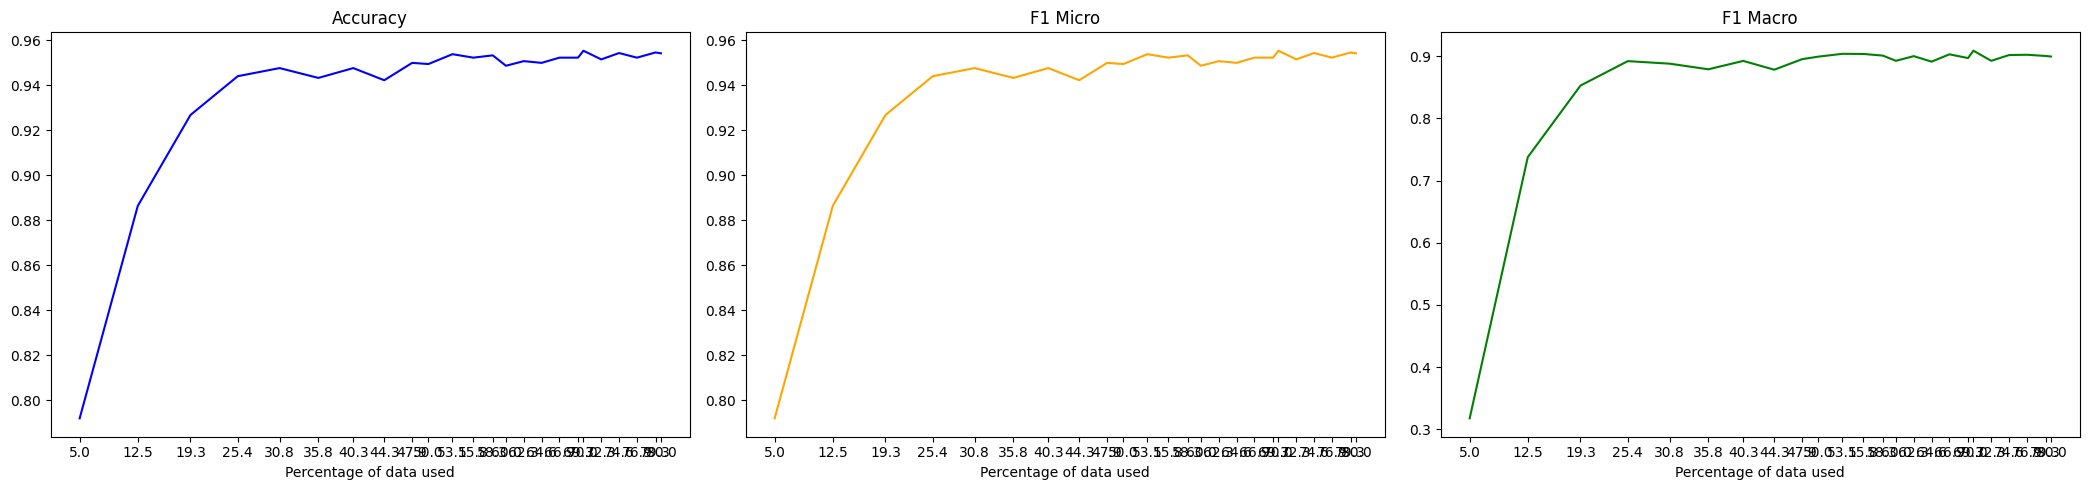

In [24]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6696, Accuracy: 0.6935, F1 Micro: 0.8002, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5881, Accuracy: 0.7775, F1 Micro: 0.8718, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5506, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8808
Epoch 4/10, Train Loss: 0.528, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4866, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4714, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.48, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4383, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.4116, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6698, Accuracy: 0.7924, F1 Micro: 0.8815, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5861, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Epoch 3/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.5332, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4877, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4812, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4841, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4614, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.4247, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.4075, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8825

Model 2 of aspect detection, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6693, Accuracy: 0.782, F1 Micro: 0.8767, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5726, Accuracy: 0.7894, F1 Micro: 0.8816, F1 Macro: 0.8798
Epoch 3/10, Train Loss: 0.5386, Accuracy: 0.7879, F1 Micro: 0.8813, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5272, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4812, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4653, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4676, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Epoch 8/10, Train Loss: 0.4355, Accuracy: 0.7902, F1 Micro: 0.8816, F1 Macro: 0.8795
Epoch 9/10, Train Loss: 0.4096, Accuracy: 0.7879, F1 Micro: 0.8795, F1 Macro: 0.8767
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6103, Accuracy: 0.7924, F1 Micro: 0.8826, F1 Macro: 0.8805
Epoch 2/10, Train Loss: 0.5351, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5061, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4865, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4228, Accuracy: 0.8051, F1 Micro: 0.8898, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3957, Accuracy: 0.8423, F1 Micro: 0.9078, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3723, Accuracy: 0.8757, F1 Micro: 0.9253, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2934, Accuracy: 0.8943, F1 Micro: 0.9357, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2682, Accuracy: 0.9137, F1 Micro: 0.9473, F1 Macro: 0.9453
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6123, Accuracy: 0.7842, F1 Micro: 0.879, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5339, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5128, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.494, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4308, Accuracy: 0.8058, F1 Micro: 0.8895, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4163, Accuracy: 0.8155, F1 Micro: 0.8926, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3849, Accuracy: 0.846, F1 Micro: 0.9085, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3026, Accuracy: 0.8832, F1 Micro: 0.9291, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.632, Accuracy: 0.7746, F1 Micro: 0.8716, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5308, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5115, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Epoch 4/10, Train Loss: 0.4978, Accuracy: 0.7917, F1 Micro: 0.8815, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4303, Accuracy: 0.7984, F1 Micro: 0.8852, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.425, Accuracy: 0.8043, F1 Micro: 0.887, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3886, Accuracy: 0.8251, F1 Micro: 0.8967, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3222, Accuracy: 0.8393, F1 Micro: 0.9048, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2855, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5258, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4947, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4543, Accuracy: 0.8155, F1 Micro: 0.8953, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4127, Accuracy: 0.8616, F1 Micro: 0.9184, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3369, Accuracy: 0.907, F1 Micro: 0.9438, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2978, Accuracy: 0.9286, F1 Micro: 0.9561, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2564, Accuracy: 0.9353, F1 Micro: 0.9598, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6033, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5222, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4953, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4551, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.421, Accuracy: 0.8564, F1 Micro: 0.9163, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.354, Accuracy: 0.901, F1 Micro: 0.9407, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3038, Accuracy: 0.9241, F1 Micro: 0.953, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2582, Accuracy: 0.9315, F1 Micro: 0.9576, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6018, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 2/10, Train Loss: 0.5339, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.501, Accuracy: 0.7932, F1 Micro: 0.8841, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4667, Accuracy: 0.8095, F1 Micro: 0.8909, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4342, Accuracy: 0.8333, F1 Micro: 0.9039, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3749, Accuracy: 0.8653, F1 Micro: 0.9192, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3253, Accuracy: 0.8973, F1 Micro: 0.9372, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2747, Accuracy: 0.9167, F1 Micro: 0.9489, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2254, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4675, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3959, Accuracy: 0.8661, F1 Micro: 0.9208, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3357, Accuracy: 0.9174, F1 Micro: 0.9498, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2822, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2362, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9684
Epoch 9/10, Train Loss: 0.159, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5852, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.516, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4752, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4237, Accuracy: 0.8497, F1 Micro: 0.9127, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3583, Accuracy: 0.9107, F1 Micro: 0.9462, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2967, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2367, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1898, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Epoch 9/10, Train Loss: 0.154, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.582, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5256, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4847, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4336, Accuracy: 0.8266, F1 Micro: 0.9006, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3837, Accuracy: 0.8832, F1 Micro: 0.9306, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3163, Accuracy: 0.9144, F1 Micro: 0.9474, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2557, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2007, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9649
Epoch 9/10, Train Loss: 0.1603, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5754, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5022, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4414, Accuracy: 0.8311, F1 Micro: 0.9033, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.362, Accuracy: 0.904, F1 Micro: 0.9414, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2981, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2241, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1815, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.969
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9674
Epoch 9/10, Train Loss: 0.1217, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5678, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5037, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4516, Accuracy: 0.811, F1 Micro: 0.8931, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3797, Accuracy: 0.9107, F1 Micro: 0.946, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3006, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2245, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9669
Epoch 7/10, Train Loss: 0.179, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.14, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.1184, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5762, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5117, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4731, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4171, Accuracy: 0.8631, F1 Micro: 0.9197, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3326, Accuracy: 0.9211, F1 Micro: 0.9514, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2499, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1981, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1528, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9699
Epoch 9/10, Train Loss: 0.1298, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5667, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4958, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.418, Accuracy: 0.8862, F1 Micro: 0.932, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3198, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2483, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1896, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1559, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5642, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5042, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4441, Accuracy: 0.8571, F1 Micro: 0.916, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3468, Accuracy: 0.9256, F1 Micro: 0.9543, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.263, Accuracy: 0.9449, F1 Micro: 0.9661, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1957, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9691
Epoch 7/10, Train Loss: 0.1607, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1194, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.1052, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5647, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5174, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4611, Accuracy: 0.8028, F1 Micro: 0.8889, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3756, Accuracy: 0.9137, F1 Micro: 0.9473, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2804, Accuracy: 0.9427, F1 Micro: 0.9645, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2085, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.1193, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1073, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5671, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4952, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4192, Accuracy: 0.8973, F1 Micro: 0.9382, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3063, Accuracy: 0.936, F1 Micro: 0.9607, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2298, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.968
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5616, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5061, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4356, Accuracy: 0.8735, F1 Micro: 0.9256, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.327, Accuracy: 0.9375, F1 Micro: 0.9615, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2381, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9676
Epoch 6/10, Train Loss: 0.1786, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.139, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.101, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5617, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5187, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.467, Accuracy: 0.8348, F1 Micro: 0.9041, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3588, Accuracy: 0.9219, F1 Micro: 0.952, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2617, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1898, Accuracy: 0.9539, F1 Micro: 0.9715, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1483, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5619, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4848, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3934, Accuracy: 0.91, F1 Micro: 0.9449, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2971, Accuracy: 0.939, F1 Micro: 0.9624, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2166, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1663, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5533, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4864, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4048, Accuracy: 0.9055, F1 Micro: 0.9429, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2961, Accuracy: 0.9397, F1 Micro: 0.9628, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2169, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1643, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0926, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5601, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5013, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4369, Accuracy: 0.869, F1 Micro: 0.9229, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3252, Accuracy: 0.9427, F1 Micro: 0.9647, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2331, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.171, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4591, Accuracy: 0.8415, F1 Micro: 0.9088, F1 Macro: 0.9081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3403, Accuracy: 0.9219, F1 Micro: 0.9519, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.261, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5499, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.48, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3629, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2751, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.972
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.7887, F1 Micro: 0.8818, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4009, Accuracy: 0.9033, F1 Micro: 0.9413, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3024, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4651, Accuracy: 0.8408, F1 Micro: 0.908, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3469, Accuracy: 0.9293, F1 Micro: 0.9566, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.257, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9708
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9531, F1 Micro: 0.9703, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4811, Accuracy: 0.8333, F1 Micro: 0.9044, F1 Macro: 0.9033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3638, Accuracy: 0.9286, F1 Micro: 0.9564, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2672, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9731
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4978, Accuracy: 0.8162, F1 Micro: 0.8955, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4045, Accuracy: 0.8988, F1 Micro: 0.9393, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2974, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9708
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0848, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.451, Accuracy: 0.8452, F1 Micro: 0.9107, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3238, Accuracy: 0.9308, F1 Micro: 0.9572, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2383, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.97
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9704
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4733, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3478, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2477, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1826, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.546, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4854, Accuracy: 0.8043, F1 Micro: 0.8894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3833, Accuracy: 0.9249, F1 Micro: 0.954, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2663, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1919, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5372, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4456, Accuracy: 0.8884, F1 Micro: 0.9329, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3104, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2327, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4712, Accuracy: 0.8557, F1 Micro: 0.9159, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3316, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4826, Accuracy: 0.8229, F1 Micro: 0.8977, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3589, Accuracy: 0.9286, F1 Micro: 0.9558, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2572, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1849, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9708
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4325, Accuracy: 0.8988, F1 Micro: 0.9387, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3125, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2217, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9726
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4478, Accuracy: 0.8728, F1 Micro: 0.925, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3318, Accuracy: 0.9405, F1 Micro: 0.9634, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.228, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9715
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 10/10, Train Loss: 0.0635, Accuracy: 0.965, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4711, Accuracy: 0.8207, F1 Micro: 0.8976, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3708, Accuracy: 0.9189, F1 Micro: 0.9498, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2504, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0776, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4284, Accuracy: 0.9077, F1 Micro: 0.9437, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2962, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9643, F1 Micro: 0.9774, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5397, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.8936, F1 Micro: 0.9366, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.313, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5458, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4789, Accuracy: 0.8251, F1 Micro: 0.9, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3512, Accuracy: 0.9286, F1 Micro: 0.9556, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9405, F1 Micro: 0.9626, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9763
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9568, F1 Micro: 0.9726, F1 Macro: 0.9698
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4194, Accuracy: 0.9003, F1 Micro: 0.9385, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2776, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4393, Accuracy: 0.9077, F1 Micro: 0.9442, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.295, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.545, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4716, Accuracy: 0.8512, F1 Micro: 0.9134, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3294, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2146, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5351, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.408, Accuracy: 0.9025, F1 Micro: 0.9399, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2889, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9719
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9583, F1 Micro: 0.9735, F1 Macro: 0.9706
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9598, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4278, Accuracy: 0.9107, F1 Micro: 0.9458, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3002, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9635, F1 Micro: 0.9768, F1 Macro: 0.975
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4603, Accuracy: 0.8467, F1 Micro: 0.9108, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3341, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2269, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9568, F1 Micro: 0.9726, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5322, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4002, Accuracy: 0.907, F1 Micro: 0.942, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2841, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1947, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0611, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4222, Accuracy: 0.9137, F1 Micro: 0.9466, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2912, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0606, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4523, Accuracy: 0.8698, F1 Micro: 0.9229, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3294, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2142, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3975, Accuracy: 0.9196, F1 Micro: 0.95, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.98
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5254, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4079, Accuracy: 0.9204, F1 Micro: 0.951, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2705, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4417, Accuracy: 0.8876, F1 Micro: 0.9326, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2981, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2049, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9806
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4044, Accuracy: 0.9211, F1 Micro: 0.9511, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2759, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9804
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9643, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4145, Accuracy: 0.9144, F1 Micro: 0.9478, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.279, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4514, Accuracy: 0.8743, F1 Micro: 0.9247, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3165, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9813
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9695, F1 Micro: 0.9807, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.394, Accuracy: 0.9211, F1 Micro: 0.9518, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2689, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5326, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4075, Accuracy: 0.9278, F1 Micro: 0.9559, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2701, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4405, Accuracy: 0.881, F1 Micro: 0.929, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2976, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.971, F1 Micro: 0.9816, F1 Macro: 0.9803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9818
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3844, Accuracy: 0.9323, F1 Micro: 0.9582, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9794
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3943, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2519, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5259, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4353, Accuracy: 0.8914, F1 Micro: 0.9346, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2891, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9808
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 10/10, Train Loss: 0.044

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3834, Accuracy: 0.9092, F1 Micro: 0.9425, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.974, F1 Micro: 0.9836, F1 Macro: 0.9828
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9725, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4023, Accuracy: 0.9219, F1 Micro: 0.9511, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4354, Accuracy: 0.901, F1 Micro: 0.9392, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2846, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9817
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3669, Accuracy: 0.9308, F1 Micro: 0.9573, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9812
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5248, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.378, Accuracy: 0.9301, F1 Micro: 0.9567, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9719
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.98
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9806
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9665, F1 Micro: 0.9787, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4266, Accuracy: 0.9129, F1 Micro: 0.9473, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2753, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5203, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3683, Accuracy: 0.9315, F1 Micro: 0.9578, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5209, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3772, Accuracy: 0.9353, F1 Micro: 0.9598, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9807
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9802
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9795
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4232, Accuracy: 0.9241, F1 Micro: 0.9534, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2555, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9801
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9673, F1 Micro: 0.9792, F1 Macr

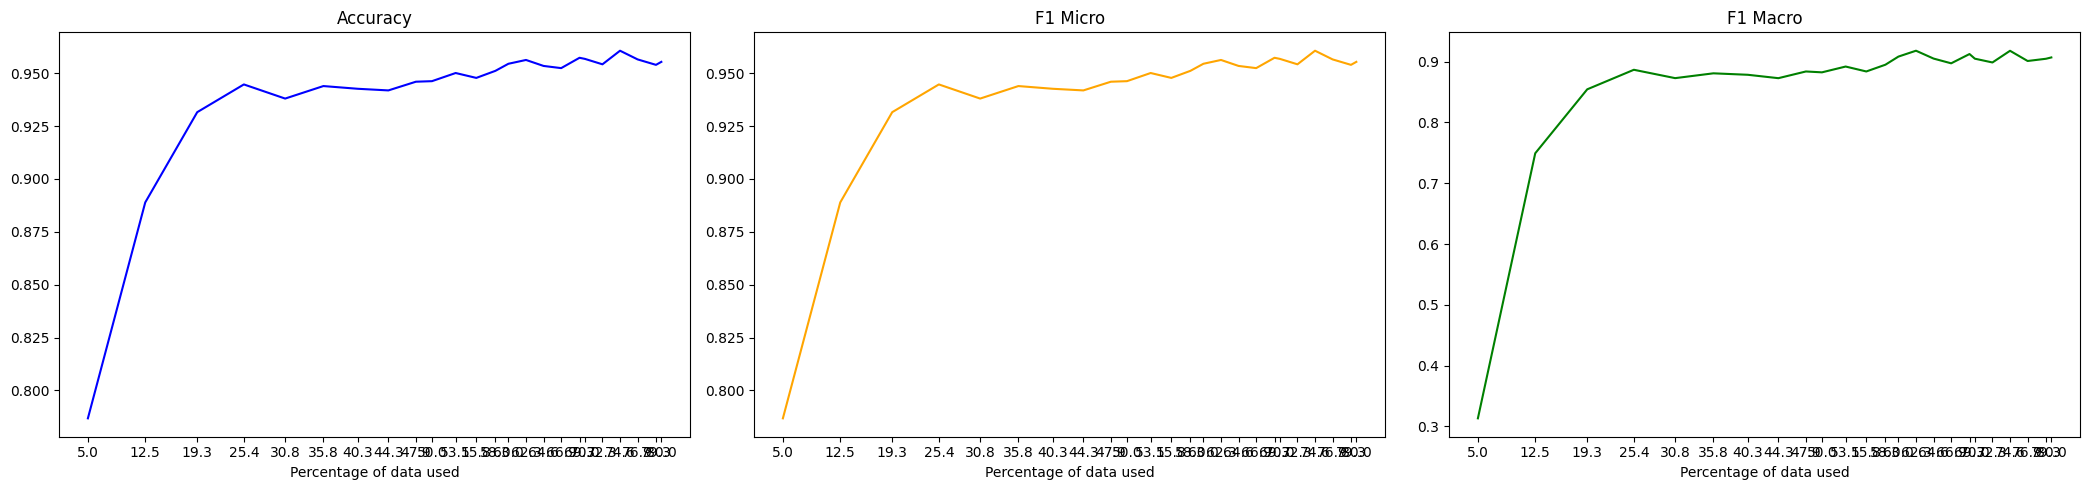

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6796, Accuracy: 0.776, F1 Micro: 0.8715, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5844, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5397, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5372, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4843, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4798, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4852, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4458, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7078, Accuracy: 0.7024, F1 Micro: 0.8155, F1 Macro: 0.7878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6021, Accuracy: 0.7872, F1 Micro: 0.8807, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5455, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5268, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4897, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Epoch 6/10, Train Loss: 0.4716, Accuracy: 0.7879, F1 Micro: 0.8805, F1 Macro: 0.8784
Epoch 7/10, Train Loss: 0.4659, Accuracy: 0.7827, F1 Micro: 0.8767, F1 Macro: 0.8734
Epoch 8/10, Train Loss: 0.4462, Accuracy: 0.7827, F1 Micro: 0.8759, F1 Macro: 0.872
Epoch 9/10, Train Loss: 0.4178, Accuracy: 0.7812, F1 Micro: 0.8752, F1 Macro: 0.8715
Epoch 10/10, Train Loss: 0.3894, Accuracy: 0.7812, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6904, Accuracy: 0.7835, F1 Micro: 0.8752, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5708, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5489, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5207, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4748, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4754, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.48, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4383, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6203, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5141, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4769, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4589, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4203, Accuracy: 0.8006, F1 Micro: 0.8876, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.811, F1 Micro: 0.8917, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3633, Accuracy: 0.8251, F1 Micro: 0.8991, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3015, Accuracy: 0.8571, F1 Micro: 0.9157, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6412, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5252, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4826, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 4/10, Train Loss: 0.4693, Accuracy: 0.7879, F1 Micro: 0.8804, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4383, Accuracy: 0.7946, F1 Micro: 0.8834, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4246, Accuracy: 0.7984, F1 Micro: 0.8852, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3841, Accuracy: 0.8162, F1 Micro: 0.8942, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3253, Accuracy: 0.8438, F1 Micro: 0.9083, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2888, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5973, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5097, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4776, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4596, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4173, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.394, Accuracy: 0.8147, F1 Micro: 0.8948, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3559, Accuracy: 0.8326, F1 Micro: 0.9041, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2991, Accuracy: 0.875, F1 Micro: 0.9258, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5917, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4738, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4774, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4294, Accuracy: 0.8036, F1 Micro: 0.8891, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3944, Accuracy: 0.8199, F1 Micro: 0.897, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3506, Accuracy: 0.8631, F1 Micro: 0.9186, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2757, Accuracy: 0.8996, F1 Micro: 0.9391, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2335, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2012, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6063, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4856, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4882, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.449, Accuracy: 0.7976, F1 Micro: 0.8853, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4168, Accuracy: 0.8043, F1 Micro: 0.8884, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3706, Accuracy: 0.8415, F1 Micro: 0.9076, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3046, Accuracy: 0.8891, F1 Micro: 0.9338, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2573, Accuracy: 0.9189, F1 Micro: 0.95, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5846, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.473, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4767, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4254, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3876, Accuracy: 0.8177, F1 Micro: 0.896, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3423, Accuracy: 0.8884, F1 Micro: 0.9332, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2751, Accuracy: 0.9107, F1 Micro: 0.9459, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2281, Accuracy: 0.9241, F1 Micro: 0.9532, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5737, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.497, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4489, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.405, Accuracy: 0.8333, F1 Micro: 0.9027, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3462, Accuracy: 0.8683, F1 Micro: 0.9213, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2919, Accuracy: 0.9152, F1 Micro: 0.9476, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2284, Accuracy: 0.9315, F1 Micro: 0.9576, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.197, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9632
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5897, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5058, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.464, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4247, Accuracy: 0.8199, F1 Micro: 0.8968, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3651, Accuracy: 0.8728, F1 Micro: 0.9244, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3028, Accuracy: 0.9234, F1 Micro: 0.9525, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2397, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2027, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5687, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4981, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4494, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4009, Accuracy: 0.8333, F1 Micro: 0.9029, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3409, Accuracy: 0.8914, F1 Micro: 0.9346, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2833, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2231, Accuracy: 0.936, F1 Micro: 0.96, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1854, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9662
Epoch 9/10, Train Loss: 0.1469, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5572, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.482, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4267, Accuracy: 0.8214, F1 Micro: 0.8978, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3758, Accuracy: 0.8765, F1 Micro: 0.9256, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2963, Accuracy: 0.9219, F1 Micro: 0.952, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2339, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1702, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1333, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5697, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4841, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4496, Accuracy: 0.8013, F1 Micro: 0.8881, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3975, Accuracy: 0.8638, F1 Micro: 0.9198, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3086, Accuracy: 0.9249, F1 Micro: 0.9535, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2401, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1719, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1364, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5522, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4779, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4266, Accuracy: 0.8289, F1 Micro: 0.9018, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3654, Accuracy: 0.9025, F1 Micro: 0.9407, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2831, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2236, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1611, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9677
Epoch 8/10, Train Loss: 0.1334, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9663
Epoch 9/10, Train Loss: 0.1071, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5472, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4683, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.412, Accuracy: 0.8475, F1 Micro: 0.91, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3279, Accuracy: 0.9129, F1 Micro: 0.9466, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2396, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1828, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9683
Epoch 7/10, Train Loss: 0.1423, Accuracy: 0.9472, F1 Micro: 0.9667, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5646, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4798, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4318, Accuracy: 0.8296, F1 Micro: 0.9017, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3503, Accuracy: 0.9122, F1 Micro: 0.9463, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2526, Accuracy: 0.9278, F1 Micro: 0.9549, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1935, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1503, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1212, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4681, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4045, Accuracy: 0.8609, F1 Micro: 0.918, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3257, Accuracy: 0.9286, F1 Micro: 0.9561, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2314, Accuracy: 0.9397, F1 Micro: 0.9626, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9699
Epoch 7/10, Train Loss: 0.1445, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4089, Accuracy: 0.8452, F1 Micro: 0.9078, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3211, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2515, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1844, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9667
Epoch 7/10, Train Loss: 0.1444, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9663
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9487, F1 Micro: 0.9678, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0882, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.554, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4672, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4131, Accuracy: 0.8356, F1 Micro: 0.9036, F1 Macro: 0.9017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.327, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2507, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1471, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.97
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9667
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4571, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3965, Accuracy: 0.8668, F1 Micro: 0.9196, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.309, Accuracy: 0.9382, F1 Micro: 0.9619, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2365, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1835, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.115, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.542, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.477, Accuracy: 0.8065, F1 Micro: 0.8903, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3948, Accuracy: 0.8713, F1 Micro: 0.922, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.291, Accuracy: 0.9301, F1 Micro: 0.9566, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.213, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1763, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4836, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4097, Accuracy: 0.8802, F1 Micro: 0.9285, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3032, Accuracy: 0.9249, F1 Micro: 0.9536, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.216, Accuracy: 0.9442, F1 Micro: 0.965, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0879, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5365, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4688, Accuracy: 0.8095, F1 Micro: 0.8921, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.379, Accuracy: 0.8936, F1 Micro: 0.9346, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2733, Accuracy: 0.9301, F1 Micro: 0.9563, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2013, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9691
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.971
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4664, Accuracy: 0.8095, F1 Micro: 0.8923, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3661, Accuracy: 0.8973, F1 Micro: 0.9369, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2738, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.195, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1182, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0745, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4722, Accuracy: 0.8028, F1 Micro: 0.8875, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3754, Accuracy: 0.9129, F1 Micro: 0.9466, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2783, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1975, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.458, Accuracy: 0.8132, F1 Micro: 0.8939, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3529, Accuracy: 0.9159, F1 Micro: 0.9477, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2629, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4679, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3758, Accuracy: 0.9003, F1 Micro: 0.9389, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2649, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5455, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4761, Accuracy: 0.8043, F1 Micro: 0.8893, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.395, Accuracy: 0.9025, F1 Micro: 0.9409, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2809, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.456, Accuracy: 0.814, F1 Micro: 0.8945, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3613, Accuracy: 0.8996, F1 Micro: 0.9383, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2542, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9501, F1 Micro: 0.9685, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4411, Accuracy: 0.8274, F1 Micro: 0.9005, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3489, Accuracy: 0.9122, F1 Micro: 0.9465, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.247, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9509, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1415, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9546, F1 Micro: 0.9712, F1 Macro: 0.9682
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4506, Accuracy: 0.8155, F1 Micro: 0.8952, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3606, Accuracy: 0.9211, F1 Micro: 0.9515, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2529, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Epoch 5/10, Train Loss: 0.1807, Accuracy: 0.9479, F1 Micro: 0.9671, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4378, Accuracy: 0.8371, F1 Micro: 0.9056, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3433, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2419, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9554, F1 Micro: 0.9716, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.539, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4468, Accuracy: 0.8356, F1 Micro: 0.9036, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.345, Accuracy: 0.9338, F1 Micro: 0.9589, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2353, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9722
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4548, Accuracy: 0.8304, F1 Micro: 0.9021, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3485, Accuracy: 0.9375, F1 Micro: 0.9614, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2414, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9621, F1 Micro: 0.976, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4418, Accuracy: 0.8445, F1 Micro: 0.909, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3282, Accuracy: 0.9301, F1 Micro: 0.9564, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0675, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5243, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4412, Accuracy: 0.8549, F1 Micro: 0.9147, F1 Macro: 0.9131


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3212, Accuracy: 0.9308, F1 Micro: 0.9574, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2157, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9713
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772

Model 1 of aspect detection, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
              precision    recall  f1-score   support

        fuel      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4554, Accuracy: 0.8199, F1 Micro: 0.8968, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3436, Accuracy: 0.9196, F1 Micro: 0.9504, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2358, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9713
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5226, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4311, Accuracy: 0.8772, F1 Micro: 0.9268, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3079, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2092, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5307, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4291, Accuracy: 0.8609, F1 Micro: 0.9182, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3066, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.215, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.443, Accuracy: 0.843, F1 Micro: 0.9089, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3183, Accuracy: 0.9375, F1 Micro: 0.9609, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2218, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5264, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4155, Accuracy: 0.8847, F1 Micro: 0.9308, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2924, Accuracy: 0.9345, F1 Micro: 0.9591, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4296, Accuracy: 0.8586, F1 Micro: 0.9142, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3172, Accuracy: 0.9412, F1 Micro: 0.9634, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4336, Accuracy: 0.869, F1 Micro: 0.9214, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3176, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.415, Accuracy: 0.8921, F1 Micro: 0.934, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2991, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9687
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5378, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4229, Accuracy: 0.8914, F1 Micro: 0.9338, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5421, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4359, Accuracy: 0.8832, F1 Micro: 0.9293, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3143, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.904, F1 Micro: 0.941, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2946, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4404, Accuracy: 0.8943, F1 Micro: 0.9355, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2934, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5378, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.8921, F1 Micro: 0.9346, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2981, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4327, Accuracy: 0.9048, F1 Micro: 0.9417, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9643, F1 Micro: 0.9775, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5292, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4197, Accuracy: 0.9077, F1 Micro: 0.9436, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2789, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 10/10, Train Loss: 0.0469, Accuracy: 0.965, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5342, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4242, Accuracy: 0.9018, F1 Micro: 0.9408, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5234, Accuracy: 0.7984, F1 Micro: 0.8865, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4123, Accuracy: 0.9182, F1 Micro: 0.9494, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 9/10, Train Loss: 0.0569, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4224, Accuracy: 0.8943, F1 Micro: 0.9349, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2929, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.968, F1 Micro: 0.9799, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4282, Accuracy: 0.907, F1 Micro: 0.9433, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2863, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9658, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.9137, F1 Micro: 0.9461, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2702, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4077, Accuracy: 0.9107, F1 Micro: 0.9452, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.971, F1 Micro: 0.9819, F1 Macro: 0.981
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4218, Accuracy: 0.9129, F1 Micro: 0.9468, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9782
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 10/10, Train Loss: 0.0461, Accuracy: 0.968, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2544, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5207, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4006, Accuracy: 0.9159, F1 Micro: 0.948, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9732, F1 Micro: 0.9831, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.9196, F1 Micro: 0.9506, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5157, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3906, Accuracy: 0.9263, F1 Micro: 0.9539, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2472, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.9085, F1 Micro: 0.9441, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.269, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4164, Accuracy: 0.91, F1 Micro: 0.9446, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2735, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3923, Accuracy: 0.9211, F1 Micro: 0.9514, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2553, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9808
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3852, Accuracy: 0.9345, F1 Micro: 0.9596, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2405, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3975, Accuracy: 0.9226, F1 Micro: 0.952, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2505, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.975
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9794
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3832, Accuracy: 0.9353, F1 Micro: 0.96, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 10/10, Train Loss: 0.0449, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5306, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3971, Accuracy: 0.9293, F1 Micro: 0.9567, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2493, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.977
Higher F1 achieved, saving 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4087, Accuracy: 0.9226, F1 Micro: 0.9525, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9769
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0.9635, F1 Micro: 0.9769, F1 

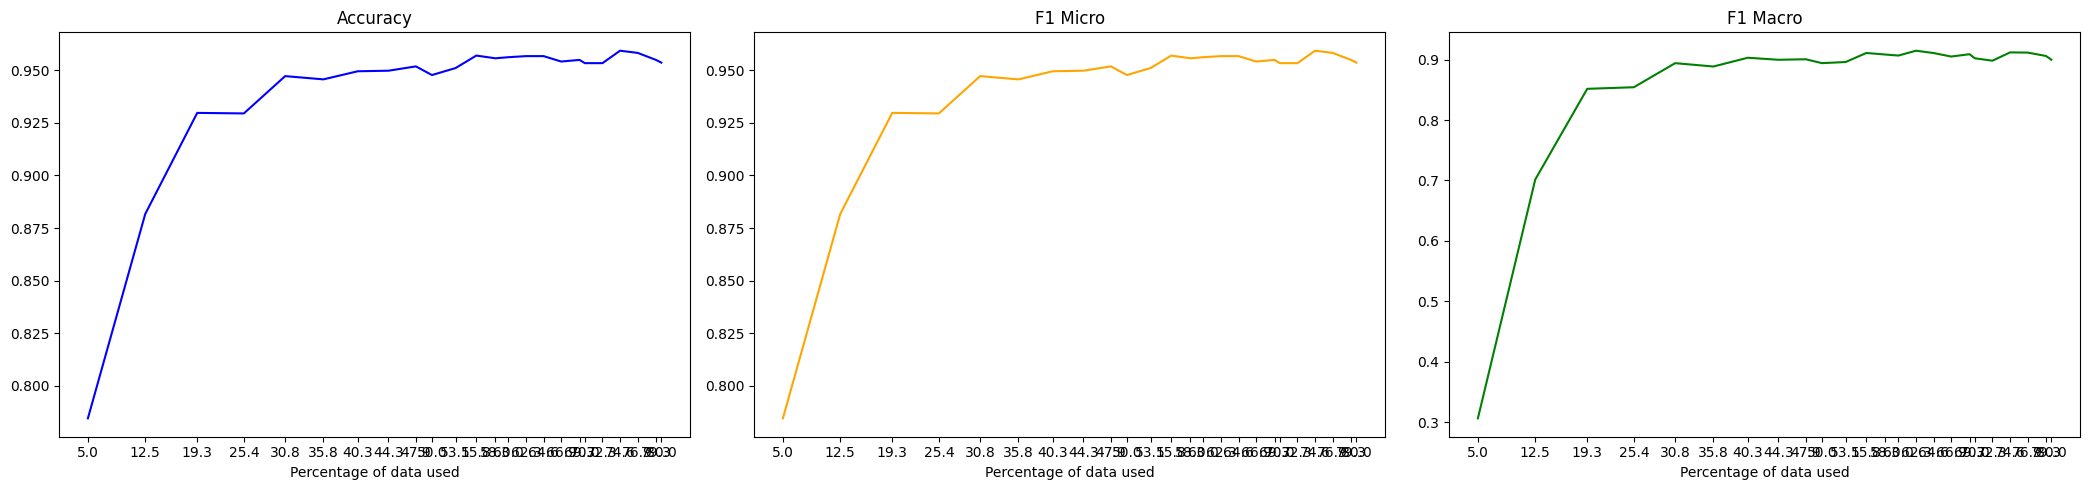

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6645, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5755, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5509, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5294, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4827, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4817, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.4898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4555, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4326, Accuracy: 0.7924, F1 Micro: 0.8837, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6903, Accuracy: 0.7671, F1 Micro: 0.8669, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5862, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 3/10, Train Loss: 0.5474, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.5251, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4831, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4764, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4815, Accuracy: 0.7887, F1 Micro: 0.8818, F1 Macro: 0.8803
Epoch 8/10, Train Loss: 0.4411, Accuracy: 0.7894, F1 Micro: 0.8821, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4087, Accuracy: 0.7969, F1 Micro: 0.8856, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3783, Accuracy: 0.8043, F1 Micro: 0.889, F1 Macro: 0.8873



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6548, Accuracy: 0.7827, F1 Micro: 0.878, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5764, Accuracy: 0.7879, F1 Micro: 0.8814, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5377, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5305, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4931, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4768, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4845, Accuracy: 0.7879, F1 Micro: 0.8814, F1 Macro: 0.8799
Epoch 8/10, Train Loss: 0.4606, Accuracy: 0.7894, F1 Micro: 0.8821, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4249, Accuracy: 0.7924, F1 Micro: 0.8834, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6152, Accuracy: 0.7783, F1 Micro: 0.8742, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5095, Accuracy: 0.7879, F1 Micro: 0.88, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5069, Accuracy: 0.7917, F1 Micro: 0.8831, F1 Macro: 0.8815
Epoch 4/10, Train Loss: 0.4873, Accuracy: 0.7932, F1 Micro: 0.8828, F1 Macro: 0.8805
Epoch 5/10, Train Loss: 0.4578, Accuracy: 0.779, F1 Micro: 0.8717, F1 Macro: 0.8639
Epoch 6/10, Train Loss: 0.425, Accuracy: 0.7887, F1 Micro: 0.8763, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3856, Accuracy: 0.8088, F1 Micro: 0.888, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3389, Accuracy: 0.8229, F1 Micro: 0.8951, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3119, Accuracy: 0.8527, F1 Micro: 0.9114, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6383, Accuracy: 0.7894, F1 Micro: 0.881, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.514, Accuracy: 0.7894, F1 Micro: 0.8819, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4982, Accuracy: 0.7939, F1 Micro: 0.8841, F1 Macro: 0.8823
Epoch 4/10, Train Loss: 0.4747, Accuracy: 0.7946, F1 Micro: 0.8833, F1 Macro: 0.881
Epoch 5/10, Train Loss: 0.4457, Accuracy: 0.7976, F1 Micro: 0.8815, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.41, Accuracy: 0.8192, F1 Micro: 0.893, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3522, Accuracy: 0.8318, F1 Micro: 0.9, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3186, Accuracy: 0.8542, F1 Micro: 0.9119, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.289, Accuracy: 0.8735, F1 Micro: 0.9224, F1 Macro: 0.917

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6253, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.517, Accuracy: 0.7879, F1 Micro: 0.8814, F1 Macro: 0.8798
Epoch 3/10, Train Loss: 0.5024, Accuracy: 0.7879, F1 Micro: 0.8794, F1 Macro: 0.8763
Epoch 4/10, Train Loss: 0.4838, Accuracy: 0.7909, F1 Micro: 0.881, F1 Macro: 0.8781
Epoch 5/10, Train Loss: 0.457, Accuracy: 0.7924, F1 Micro: 0.8811, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4301, Accuracy: 0.8013, F1 Micro: 0.8851, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3833, Accuracy: 0.8147, F1 Micro: 0.8919, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3503, Accuracy: 0.8333, F1 Micro: 0.9007, F1 Macro: 0.8972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3145, Accuracy: 0.8557, F1 Micro: 0.913, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5843, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5099, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4802, Accuracy: 0.7946, F1 Micro: 0.8847, F1 Macro: 0.8831
Epoch 4/10, Train Loss: 0.4557, Accuracy: 0.7939, F1 Micro: 0.8823, F1 Macro: 0.8793
Epoch 5/10, Train Loss: 0.4163, Accuracy: 0.7999, F1 Micro: 0.8836, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3749, Accuracy: 0.8445, F1 Micro: 0.9065, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.298, Accuracy: 0.8847, F1 Micro: 0.9293, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2591, Accuracy: 0.901, F1 Micro: 0.9389, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2058, Accuracy: 0.9092, F1 Micro: 0.943, F1 Macro: 0.9386
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5995, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5018, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.468, Accuracy: 0.7976, F1 Micro: 0.886, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4334, Accuracy: 0.8251, F1 Micro: 0.8988, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3845, Accuracy: 0.8579, F1 Micro: 0.9156, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.334, Accuracy: 0.8981, F1 Micro: 0.9379, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2586, Accuracy: 0.9234, F1 Micro: 0.9524, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2244, Accuracy: 0.9308, F1 Micro: 0.9565, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5908, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.52, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4927, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4677, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4312, Accuracy: 0.8185, F1 Micro: 0.8961, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4036, Accuracy: 0.8497, F1 Micro: 0.911, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3169, Accuracy: 0.8966, F1 Micro: 0.9372, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2647, Accuracy: 0.9226, F1 Micro: 0.9521, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5807, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5254, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4811, Accuracy: 0.7976, F1 Micro: 0.8861, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4344, Accuracy: 0.8051, F1 Micro: 0.888, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3795, Accuracy: 0.8519, F1 Micro: 0.9111, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3214, Accuracy: 0.8988, F1 Micro: 0.938, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2577, Accuracy: 0.9211, F1 Micro: 0.9509, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1989, Accuracy: 0.9308, F1 Micro: 0.9564, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1629, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.586, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5216, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4633, Accuracy: 0.8065, F1 Micro: 0.8896, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4058, Accuracy: 0.8542, F1 Micro: 0.9141, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3276, Accuracy: 0.9115, F1 Micro: 0.9458, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2788, Accuracy: 0.9301, F1 Micro: 0.9564, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2308, Accuracy: 0.939, F1 Micro: 0.9618, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1769, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5877, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.5247, Accuracy: 0.7894, F1 Micro: 0.8821, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4824, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4519, Accuracy: 0.8088, F1 Micro: 0.8913, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3895, Accuracy: 0.8646, F1 Micro: 0.9198, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3308, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2632, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2068, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1676, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5593, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4949, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4689, Accuracy: 0.8058, F1 Micro: 0.8895, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4119, Accuracy: 0.8549, F1 Micro: 0.9128, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3126, Accuracy: 0.904, F1 Micro: 0.9406, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2516, Accuracy: 0.936, F1 Micro: 0.96, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1916, Accuracy: 0.9487, F1 Micro: 0.9678, F1 Macro: 0.9662
Epoch 8/10, Train Loss: 0.1482, Accuracy: 0.9412, F1 Micro: 0.9628, F1 Macro: 0.9596
Epoch 9/10, Train Loss: 0.1287, Accuracy: 0.9427, F1 Micro: 0.9637, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5686, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4906, Accuracy: 0.7999, F1 Micro: 0.8868, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4528, Accuracy: 0.8341, F1 Micro: 0.9045, F1 Macro: 0.9034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3692, Accuracy: 0.8996, F1 Micro: 0.9382, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.284, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2272, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1773, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9694
Epoch 8/10, Train Loss: 0.1406, Accuracy: 0.9412, F1 Micro: 0.9628, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1216, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5758, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5001, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4822, Accuracy: 0.7999, F1 Micro: 0.8873, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4245, Accuracy: 0.8646, F1 Micro: 0.92, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3291, Accuracy: 0.9234, F1 Micro: 0.9526, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2659, Accuracy: 0.933, F1 Micro: 0.9577, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2027, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1608, Accuracy: 0.9479, F1 Micro: 0.967, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5632, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4802, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4407, Accuracy: 0.8185, F1 Micro: 0.8948, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.357, Accuracy: 0.8914, F1 Micro: 0.9337, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2691, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.202, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.97
Epoch 7/10, Train Loss: 0.1514, Accuracy: 0.9479, F1 Micro: 0.9672, F1 Macro: 0.9651
Epoch 8/10, Train Loss: 0.1226, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4715, Accuracy: 0.808, F1 Micro: 0.8914, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3968, Accuracy: 0.8817, F1 Micro: 0.9295, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3082, Accuracy: 0.9382, F1 Micro: 0.9617, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2332, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1742, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.1349, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.094, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5688, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4874, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4535, Accuracy: 0.814, F1 Micro: 0.8938, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3813, Accuracy: 0.9055, F1 Micro: 0.9428, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2834, Accuracy: 0.939, F1 Micro: 0.9622, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2046, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.157, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5516, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4938, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4366, Accuracy: 0.817, F1 Micro: 0.8953, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3519, Accuracy: 0.9062, F1 Micro: 0.9425, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2607, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1921, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.967
Epoch 7/10, Train Loss: 0.1441, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9494, F1 Micro: 0.9681, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0961, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4808, Accuracy: 0.7999, F1 Micro: 0.8874, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3938, Accuracy: 0.8787, F1 Micro: 0.9278, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2986, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2221, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1667, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9707
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4974, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4386, Accuracy: 0.8274, F1 Micro: 0.9011, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.349, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2576, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1891, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9708
Epoch 7/10, Train Loss: 0.1443, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.97
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9677
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9675
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5372, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4968, Accuracy: 0.8021, F1 Micro: 0.8878, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4125, Accuracy: 0.8653, F1 Micro: 0.919, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3112, Accuracy: 0.9189, F1 Micro: 0.9496, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2356, Accuracy: 0.9464, F1 Micro: 0.9662, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1701, Accuracy: 0.9472, F1 Micro: 0.9669, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1336, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5394, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4811, Accuracy: 0.8371, F1 Micro: 0.9056, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3698, Accuracy: 0.9167, F1 Micro: 0.9494, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2675, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2053, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5027, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4255, Accuracy: 0.8549, F1 Micro: 0.9151, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3217, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2363, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9708
Epoch 7/10, Train Loss: 0.1369, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9694
Epoch 8/10, Train Loss: 0.1131, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9576, F1 Micro: 0.9735, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5502, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4837, Accuracy: 0.8013, F1 Micro: 0.888, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.386, Accuracy: 0.8988, F1 Micro: 0.9388, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2715, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2016, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4678, Accuracy: 0.843, F1 Micro: 0.9093, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3454, Accuracy: 0.9263, F1 Micro: 0.9548, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2407, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5529, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4952, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4023, Accuracy: 0.9048, F1 Micro: 0.9426, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2777, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1968, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9717
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9695
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9516, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9568, F1 Micro: 0.9728, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5421, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4808, Accuracy: 0.8103, F1 Micro: 0.8905, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3886, Accuracy: 0.9003, F1 Micro: 0.9386, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2743, Accuracy: 0.9405, F1 Micro: 0.9631, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5436, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4559, Accuracy: 0.8586, F1 Micro: 0.9162, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3447, Accuracy: 0.9301, F1 Micro: 0.957, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2447, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.969
Epoch 5/10, Train Loss: 0.186, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.9703
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5471, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4874, Accuracy: 0.8058, F1 Micro: 0.8902, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4007, Accuracy: 0.9025, F1 Micro: 0.9412, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2809, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2005, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0747, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.539, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4783, Accuracy: 0.8058, F1 Micro: 0.8899, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3766, Accuracy: 0.9196, F1 Micro: 0.9511, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2518, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1834, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4546, Accuracy: 0.8571, F1 Micro: 0.9168, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3331, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2221, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5402, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4766, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3789, Accuracy: 0.9249, F1 Micro: 0.9543, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2492, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1849, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.47, Accuracy: 0.8088, F1 Micro: 0.8907, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3579, Accuracy: 0.9182, F1 Micro: 0.9493, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2372, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5493, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4518, Accuracy: 0.8698, F1 Micro: 0.9231, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3247, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2132, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5447, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4797, Accuracy: 0.8095, F1 Micro: 0.8921, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3768, Accuracy: 0.9293, F1 Micro: 0.9563, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2494, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0761, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5361, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4569, Accuracy: 0.8251, F1 Micro: 0.8988, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3479, Accuracy: 0.9263, F1 Micro: 0.9551, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5422, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4242, Accuracy: 0.8943, F1 Micro: 0.9364, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3021, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4644, Accuracy: 0.8266, F1 Micro: 0.9007, F1 Macro: 0.8995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3554, Accuracy: 0.9353, F1 Micro: 0.9603, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2337, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1682, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5304, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4575, Accuracy: 0.8311, F1 Micro: 0.9028, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3181, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2225, Accuracy: 0.9449, F1 Micro: 0.9654, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.8795, F1 Micro: 0.9288, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.293, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.467, Accuracy: 0.8289, F1 Micro: 0.9021, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3245, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2274, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5376, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.45, Accuracy: 0.8318, F1 Micro: 0.9028, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3202, Accuracy: 0.9397, F1 Micro: 0.9625, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4231, Accuracy: 0.9025, F1 Micro: 0.9412, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2836, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9804
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9673, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4566, Accuracy: 0.8452, F1 Micro: 0.9103, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3205, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9737
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4515, Accuracy: 0.8341, F1 Micro: 0.9042, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.32, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4091, Accuracy: 0.8996, F1 Micro: 0.9396, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2785, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9783
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5357, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4513, Accuracy: 0.8348, F1 Micro: 0.905, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.316, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5283, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4352, Accuracy: 0.8668, F1 Micro: 0.9208, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3142, Accuracy: 0.9427, F1 Micro: 0.9647, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5343, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4089, Accuracy: 0.9137, F1 Micro: 0.9475, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2828, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4514, Accuracy: 0.8534, F1 Micro: 0.9144, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3159, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2021, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9723
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4323, Accuracy: 0.8668, F1 Micro: 0.9216, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2924, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9673, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3938, Accuracy: 0.9219, F1 Micro: 0.9524, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2548, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9752
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9628, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.98
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.8743, F1 Micro: 0.9259, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2882, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9713
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9539, F1 Micro: 0.9708, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.7932, F1 Micro: 0.8838, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4359, Accuracy: 0.8847, F1 Micro: 0.929, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.302, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5198, Accuracy: 0.8006, F1 Micro: 0.8878, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.9226, F1 Micro: 0.952, F1 Macro: 0.9495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2681, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9774
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5204, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4445, Accuracy: 0.8936, F1 Micro: 0.9354, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3076, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4347, Accuracy: 0.8914, F1 Micro: 0.9351, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2742, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3926, Accuracy: 0.9219, F1 Micro: 0.9522, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2462, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9688, F1 Micro: 0.9805, F1 Macro: 0.9796
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9739
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.9621, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5372, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4427, Accuracy: 0.8854, F1 Micro: 0.932, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2796, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4165, Accuracy: 0.8943, F1 Micro: 0.9339, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9688, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5263, Accuracy: 0.8036, F1 Micro: 0.8894, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3839, Accuracy: 0.9353, F1 Micro: 0.9598, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9814
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4373, Accuracy: 0.91, F1 Micro: 0.9448, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2752, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4199, Accuracy: 0.9003, F1 Micro: 0.9384, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3785, Accuracy: 0.9263, F1 Micro: 0.954, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2443, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9785
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5312, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4286, Accuracy: 0.9159, F1 Micro: 0.9484, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2731, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9658, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4117, Accuracy: 0.8862, F1 Micro: 0.9314, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5249, Accuracy: 0.8103, F1 Micro: 0.8921, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3766, Accuracy: 0.9301, F1 Micro: 0.9569, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7879, F1 Micro: 0.8813, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4237, Accuracy: 0.9085, F1 Micro: 0.9446, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2611, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5205, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.405, Accuracy: 0.9144, F1 Micro: 0.947, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.9315, F1 Micro: 0.9571, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9769
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9817
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4232, Accuracy: 0.9278, F1 Micro: 0.9557, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2558, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9764
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9628, F1 Micro: 0.9764, F1 

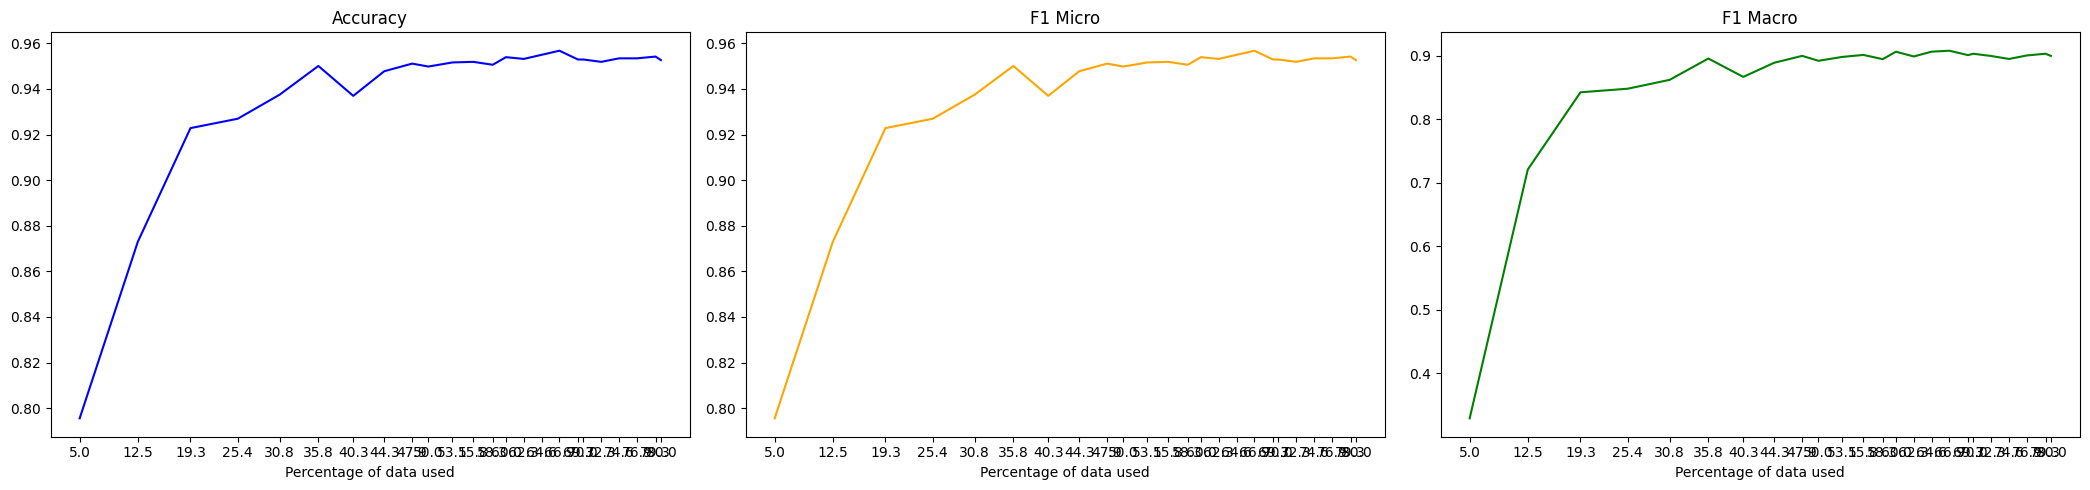

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6559, Accuracy: 0.7463, F1 Micro: 0.8496, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5772, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5458, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5239, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.476, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4654, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4704, Accuracy: 0.7879, F1 Micro: 0.8808, F1 Macro: 0.8789
Epoch 8/10, Train Loss: 0.4263, Accuracy: 0.7827, F1 Micro: 0.8771, F1 Macro: 0.8742
Epoch 9/10, Train Loss: 0.4009, Accuracy: 0.7812, F1 Micro: 0.8761, F1 Macro: 0.8731
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6744, Accuracy: 0.7552, F1 Micro: 0.8555, F1 Macro: 0.8479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5918, Accuracy: 0.785, F1 Micro: 0.8794, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5453, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5309, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4879, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4745, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4859, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4599, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7408, Accuracy: 0.5982, F1 Micro: 0.7065, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6394, Accuracy: 0.7723, F1 Micro: 0.8672, F1 Macro: 0.8576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6003, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 4/10, Train Loss: 0.5587, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.5047, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.5075, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.5115, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4764, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.4545, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.4405, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6071, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5272, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.49, Accuracy: 0.7902, F1 Micro: 0.8824, F1 Macro: 0.8808
Epoch 4/10, Train Loss: 0.4677, Accuracy: 0.7894, F1 Micro: 0.8805, F1 Macro: 0.8779
Epoch 5/10, Train Loss: 0.4441, Accuracy: 0.7924, F1 Micro: 0.8815, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4249, Accuracy: 0.8028, F1 Micro: 0.8867, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4034, Accuracy: 0.8222, F1 Micro: 0.8971, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3395, Accuracy: 0.8438, F1 Micro: 0.9081, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2869, Accuracy: 0.8624, F1 Micro: 0.9168, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6484, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.539, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4916, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 4/10, Train Loss: 0.478, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4482, Accuracy: 0.7984, F1 Micro: 0.885, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.424, Accuracy: 0.8021, F1 Micro: 0.8858, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3993, Accuracy: 0.8296, F1 Micro: 0.9001, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3397, Accuracy: 0.8646, F1 Micro: 0.9192, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2883, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6745, Accuracy: 0.7537, F1 Micro: 0.8532, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5552, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.508, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5003, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4702, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4546, Accuracy: 0.8051, F1 Micro: 0.8896, F1 Macro: 0.8882
Epoch 7/10, Train Loss: 0.4485, Accuracy: 0.8065, F1 Micro: 0.8886, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3818, Accuracy: 0.8423, F1 Micro: 0.9074, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3363, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5851, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5174, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.505, Accuracy: 0.7969, F1 Micro: 0.8856, F1 Macro: 0.884
Epoch 4/10, Train Loss: 0.4492, Accuracy: 0.7924, F1 Micro: 0.8834, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4321, Accuracy: 0.8155, F1 Micro: 0.894, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3652, Accuracy: 0.8438, F1 Micro: 0.909, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3197, Accuracy: 0.8817, F1 Micro: 0.929, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2617, Accuracy: 0.9234, F1 Micro: 0.9528, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2041, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.604, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5138, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5052, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4541, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4295, Accuracy: 0.808, F1 Micro: 0.8895, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3623, Accuracy: 0.8661, F1 Micro: 0.9212, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3186, Accuracy: 0.8906, F1 Micro: 0.9339, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.265, Accuracy: 0.9144, F1 Micro: 0.9478, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6466, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5279, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5166, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4746, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4489, Accuracy: 0.8073, F1 Micro: 0.891, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3929, Accuracy: 0.843, F1 Micro: 0.9084, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3399, Accuracy: 0.8832, F1 Micro: 0.9296, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2821, Accuracy: 0.9196, F1 Micro: 0.9505, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5892, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5212, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4668, Accuracy: 0.8013, F1 Micro: 0.8881, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4232, Accuracy: 0.8222, F1 Micro: 0.8977, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3752, Accuracy: 0.8638, F1 Micro: 0.9196, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2988, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2355, Accuracy: 0.933, F1 Micro: 0.9583, F1 Macro: 0.9556
Epoch 8/10, Train Loss: 0.1874, Accuracy: 0.9293, F1 Micro: 0.9557, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1489, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5983, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.524, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.7932, F1 Micro: 0.8841, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8356, F1 Micro: 0.9049, F1 Macro: 0.9033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3644, Accuracy: 0.8772, F1 Micro: 0.926, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2895, Accuracy: 0.9115, F1 Micro: 0.9458, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.233, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1853, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.15

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6425, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.532, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4854, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4454, Accuracy: 0.814, F1 Micro: 0.8941, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4003, Accuracy: 0.8631, F1 Micro: 0.9187, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3229, Accuracy: 0.9137, F1 Micro: 0.9467, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2598, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.9583
Epoch 8/10, Train Loss: 0.2015, Accuracy: 0.9338, F1 Micro: 0.9586, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1727, Accuracy: 0.9382, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5659, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4971, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4537, Accuracy: 0.8199, F1 Micro: 0.8973, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3879, Accuracy: 0.8646, F1 Micro: 0.9198, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3153, Accuracy: 0.9219, F1 Micro: 0.9523, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2349, Accuracy: 0.9427, F1 Micro: 0.9643, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1805, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9669
Epoch 9/10, Train Loss: 0.115, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5763, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4959, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4529, Accuracy: 0.8073, F1 Micro: 0.891, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3901, Accuracy: 0.8757, F1 Micro: 0.9258, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3207, Accuracy: 0.9129, F1 Micro: 0.9467, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.24, Accuracy: 0.9353, F1 Micro: 0.96, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1896, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9646
Epoch 8/10, Train Loss: 0.145, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1193, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6111, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5085, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4713, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4117, Accuracy: 0.8571, F1 Micro: 0.9164, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.343, Accuracy: 0.9226, F1 Micro: 0.9525, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2619, Accuracy: 0.9397, F1 Micro: 0.9624, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2019, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1536, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5649, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4773, Accuracy: 0.8036, F1 Micro: 0.8888, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4331, Accuracy: 0.8363, F1 Micro: 0.9053, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3483, Accuracy: 0.8973, F1 Micro: 0.9383, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2671, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9632
Epoch 6/10, Train Loss: 0.1974, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9611
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.936, F1 Micro: 0.9598, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1168, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0979, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5699, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4866, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4326, Accuracy: 0.8341, F1 Micro: 0.9045, F1 Macro: 0.9034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3534, Accuracy: 0.901, F1 Micro: 0.9397, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2723, Accuracy: 0.9382, F1 Micro: 0.9617, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2119, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9652
Epoch 7/10, Train Loss: 0.1572, Accuracy: 0.9457, F1 Micro: 0.966, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1052, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6012, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4937, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4653, Accuracy: 0.8147, F1 Micro: 0.8947, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3851, Accuracy: 0.8929, F1 Micro: 0.9355, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.298, Accuracy: 0.9375, F1 Micro: 0.9608, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2226, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9673
Epoch 7/10, Train Loss: 0.1659, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1324, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.11, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.558, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4758, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4272, Accuracy: 0.8571, F1 Micro: 0.9159, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3221, Accuracy: 0.9405, F1 Micro: 0.9634, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2398, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1765, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5662, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4802, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4329, Accuracy: 0.8527, F1 Micro: 0.9137, F1 Macro: 0.9126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3389, Accuracy: 0.9115, F1 Micro: 0.9456, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2585, Accuracy: 0.9397, F1 Micro: 0.9628, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1896, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9706
Epoch 8/10, Train Loss: 0.122, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9682
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Ma

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5945, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4885, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4564, Accuracy: 0.8341, F1 Micro: 0.9041, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3593, Accuracy: 0.9174, F1 Micro: 0.949, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2757, Accuracy: 0.942, F1 Micro: 0.9638, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2034, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.157, Accuracy: 0.9643, F1 Micro: 0.9778, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.1298, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4821, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4238, Accuracy: 0.8661, F1 Micro: 0.9211, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3158, Accuracy: 0.942, F1 Micro: 0.9642, F1 Macro: 0.9629
Epoch 5/10, Train Loss: 0.2226, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9598, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4828, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4118, Accuracy: 0.8802, F1 Micro: 0.9284, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3132, Accuracy: 0.9315, F1 Micro: 0.9576, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2238, Accuracy: 0.942, F1 Micro: 0.9637, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1724, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1382, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0915, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4942, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4372, Accuracy: 0.8616, F1 Micro: 0.9186, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3301, Accuracy: 0.9278, F1 Micro: 0.955, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.239, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1814, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.1136, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.097, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.477, Accuracy: 0.8162, F1 Micro: 0.8957, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3816, Accuracy: 0.8981, F1 Micro: 0.9385, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2753, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9576, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4799, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3678, Accuracy: 0.9062, F1 Micro: 0.9427, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.936, F1 Micro: 0.9598, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1941, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5698, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4951, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3996, Accuracy: 0.9003, F1 Micro: 0.9396, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3007, Accuracy: 0.933, F1 Micro: 0.9581, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2102, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.1344, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5471, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4894, Accuracy: 0.817, F1 Micro: 0.8959, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3988, Accuracy: 0.8914, F1 Micro: 0.9348, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2816, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1995, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9697
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5574, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4907, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3888, Accuracy: 0.9107, F1 Micro: 0.9457, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2789, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2004, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9687
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5782, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5048, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4205, Accuracy: 0.9048, F1 Micro: 0.9424, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3096, Accuracy: 0.9412, F1 Micro: 0.9634, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2234, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0904, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5375, Accuracy: 0.7976, F1 Micro: 0.8858, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4785, Accuracy: 0.8237, F1 Micro: 0.8993, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3825, Accuracy: 0.9271, F1 Micro: 0.9553, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2587, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1856, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.7909, F1 Micro: 0.8826, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4829, Accuracy: 0.8118, F1 Micro: 0.8934, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3715, Accuracy: 0.9271, F1 Micro: 0.9551, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.259, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1914, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9691
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9728
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5623, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4879, Accuracy: 0.8147, F1 Micro: 0.8948, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3988, Accuracy: 0.907, F1 Micro: 0.9436, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.277, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2056, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5421, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4829, Accuracy: 0.8311, F1 Micro: 0.9033, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3668, Accuracy: 0.9293, F1 Micro: 0.9569, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2455, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5536, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4847, Accuracy: 0.8155, F1 Micro: 0.8951, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3588, Accuracy: 0.9204, F1 Micro: 0.9511, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2465, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5685, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4969, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3754, Accuracy: 0.9263, F1 Micro: 0.9545, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2611, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.458, Accuracy: 0.84, F1 Micro: 0.9074, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3481, Accuracy: 0.9315, F1 Micro: 0.9574, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2315, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4551, Accuracy: 0.8557, F1 Micro: 0.9148, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3359, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2268, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.965, F1 Micro: 0.978, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4735, Accuracy: 0.8244, F1 Micro: 0.8987, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3713, Accuracy: 0.9308, F1 Micro: 0.9569, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2471, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9576, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5457, Accuracy: 0.8036, F1 Micro: 0.8892, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4632, Accuracy: 0.8371, F1 Micro: 0.9064, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3392, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2357, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4599, Accuracy: 0.8497, F1 Micro: 0.9129, F1 Macro: 0.9118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.34, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.237, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5669, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4682, Accuracy: 0.8326, F1 Micro: 0.9039, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3485, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2475, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9714
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.7984, F1 Micro: 0.8861, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8534, F1 Micro: 0.9148, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3156, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0604, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4464, Accuracy: 0.8884, F1 Micro: 0.9331, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3027, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2052, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.468, Accuracy: 0.8586, F1 Micro: 0.9175, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.324, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2176, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.8013, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4518, Accuracy: 0.8683, F1 Micro: 0.9227, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.31, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0584, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4528, Accuracy: 0.869, F1 Micro: 0.923, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3188, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.47, Accuracy: 0.8482, F1 Micro: 0.9121, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3329, Accuracy: 0.939, F1 Micro: 0.9618, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5414, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4387, Accuracy: 0.8869, F1 Micro: 0.9323, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3027, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4405, Accuracy: 0.8921, F1 Micro: 0.9346, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3133, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.563, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4546, Accuracy: 0.8743, F1 Micro: 0.9256, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3264, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5249, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.438, Accuracy: 0.8988, F1 Micro: 0.9387, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4351, Accuracy: 0.8958, F1 Micro: 0.9366, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2933, Accuracy: 0.9479, F1 Micro: 0.9678, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4628, Accuracy: 0.8705, F1 Micro: 0.9228, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9797
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4229, Accuracy: 0.8802, F1 Micro: 0.9287, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2819, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4163, Accuracy: 0.8876, F1 Micro: 0.9321, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9806
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5563, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4572, Accuracy: 0.8564, F1 Micro: 0.9162, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3249, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9774
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.9055, F1 Micro: 0.9429, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2698, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4169, Accuracy: 0.9062, F1 Micro: 0.9433, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2806, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9724
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9794
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.553, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8996, F1 Micro: 0.9392, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.298, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5179, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4157, Accuracy: 0.9033, F1 Micro: 0.941, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2584, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4086, Accuracy: 0.907, F1 Micro: 0.9425, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2664, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5441, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4303, Accuracy: 0.9033, F1 Micro: 0.9404, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4198, Accuracy: 0.91, F1 Micro: 0.9456, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5353, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4051, Accuracy: 0.9085, F1 Micro: 0.9442, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2613, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9714
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9732, F1 Micro: 0.9832, F1 Macro: 0.9824
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4322, Accuracy: 0.9107, F1 Micro: 0.9453, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.515, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.402, Accuracy: 0.9226, F1 Micro: 0.9528, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.251, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5173, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3964, Accuracy: 0.9122, F1 Micro: 0.9461, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2636, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4216, Accuracy: 0.9115, F1 Micro: 0.9453, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2727, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.979
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5195, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4032, Accuracy: 0.9196, F1 Micro: 0.9508, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.979
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5298, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4095, Accuracy: 0.9025, F1 Micro: 0.9402, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2556, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5459, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.9129, F1 Micro: 0.9461, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2586, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9751
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9805
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9812
Epoch 10/10, Train Los

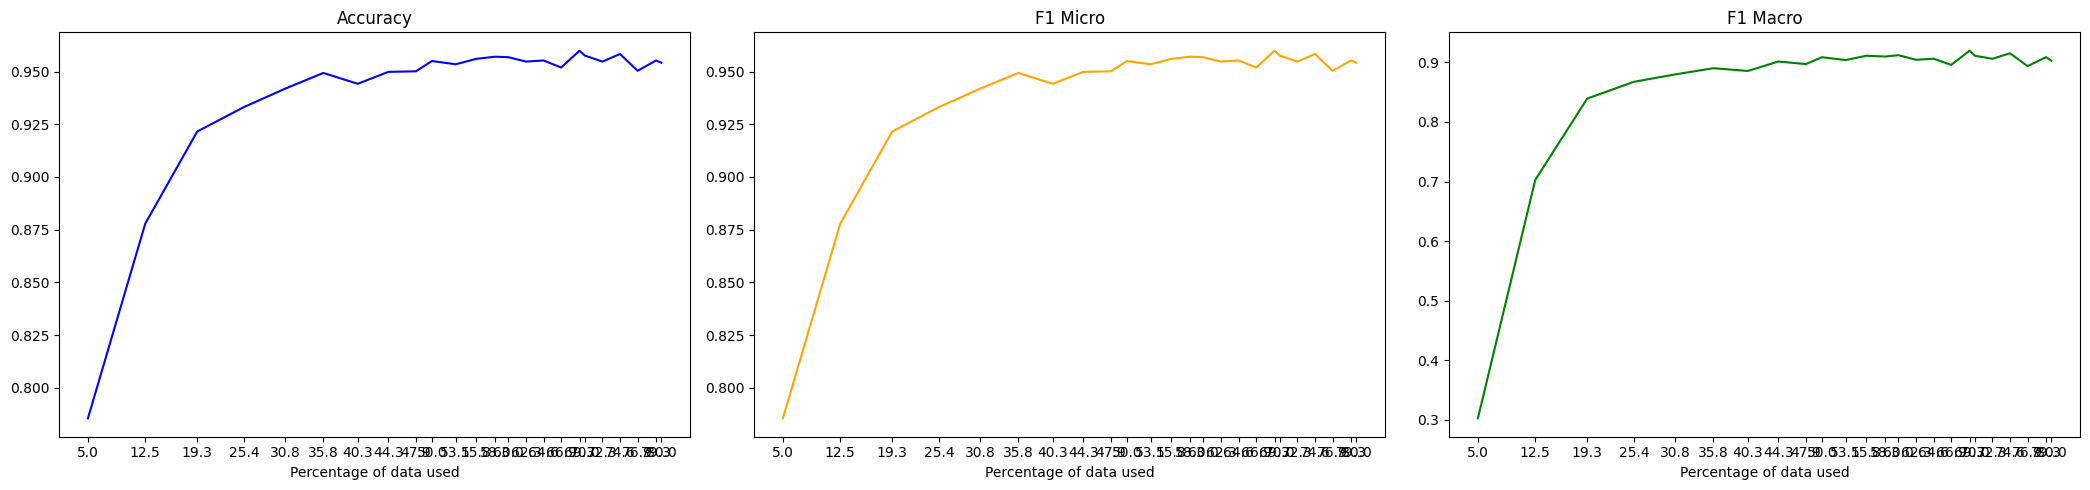

In [ ]:
active_learning(seeds[4], 4)